In [ ]:
# Task 3: Energy Consumption Time Series Forecasting

import importlib
import sys
import subprocess
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

df = pd.read_csv(
    r"C:\Users\hp\Downloads\household_power_consumption\household_power_consumption.txt",
    sep=";",
    parse_dates={'datetime': ['Date', 'Time']},
    infer_datetime_format=True,
    na_values=['?'],
    low_memory=False
)

print("Initial shape:", df.shape)
df.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_14952\2966373107.py:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(
C:\Users\hp\AppData\Local\Temp\ipykernel_14952\2966373107.py:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(
C:\Users\hp\AppData\Local\Temp\ipykernel_14952\2966373107.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(


Initial shape: (2075259, 8)


,datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:

df = df[['datetime', 'Global_active_power']]
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

# Resample to hourly consumption
df = df.set_index('datetime')
df = df.resample('H').mean()

print("After resampling:", df.shape)
df.head()



C:\Users\hp\AppData\Local\Temp\ipykernel_14952\2842240528.py:11: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('H').mean()


After resampling: (34589, 1)


,Global_active_power
datetime,
2006-12-16 17:00:00,4.222889
2006-12-16 18:00:00,3.632200
2006-12-16 19:00:00,3.400233
2006-12-16 20:00:00,3.268567
2006-12-16 21:00:00,3.056467


In [ ]:
# Data Preprocessing
df = df[['datetime', 'Global_active_power']]
df = df.dropna()
df['Global_active_power'] = df['Global_active_power'].astype(float)

# Resample to hourly consumption
df = df.set_index('datetime')
df = df.resample('H').mean()

print("After resampling:", df.shape)
df.head()


KeyError: "['datetime'] not in index"

In [ ]:
#Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

In [ ]:
#Train-Test Split
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print("Train shape:", train.shape, "Test shape:", test.shape)

Train shape: (27671, 4) Test shape: (6918, 4)


In [ ]:

# ARIMA Model

arima_model = ARIMA(train['Global_active_power'], order=(5,1,2))
arima_fit = arima_model.fit()
arima_forecast = arima_fit.forecast(steps=len(test))

prophet = Prophet()
# Prepare training data for Prophet
prophet_df = train.reset_index()[['datetime', 'Global_active_power']].rename(
    columns={'datetime': 'ds', 'Global_active_power': 'y'}
)

prophet.fit(prophet_df)

future = pd.DataFrame(test.index).rename(columns={'datetime':'ds'})
forecast = prophet.predict(future)
prophet_forecast = forecast['yhat'].values


15:11:15 - cmdstanpy - INFO - Chain [1] start processing
15:11:28 - cmdstanpy - INFO - Chain [1] done processing


In [ ]:

#Prophet Model

prophet_df = train.reset_index()[['datetime', 'Global_active_power']].rename(
    columns={'datetime':'ds','Global_active_power':'y'}
)

In [ ]:

# 8. Random Forest Model 

from sklearn.ensemble import RandomForestRegressor

def create_features(df):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

# Create features
train_rf = create_features(train)
test_rf = create_features(test)

X_train = train_rf[['hour', 'dayofweek', 'month']]
y_train = train_rf['Global_active_power']
X_test = test_rf[['hour', 'dayofweek', 'month']]
y_test = test_rf['Global_active_power']

# Combine into one DataFrame to drop NaNs consistently
train_data = pd.concat([X_train, y_train], axis=1).dropna()
test_data = pd.concat([X_test, y_test], axis=1).dropna()

X_train = train_data[['hour', 'dayofweek', 'month']]
y_train = train_data['Global_active_power']
X_test = test_data[['hour', 'dayofweek', 'month']]
y_test = test_data['Global_active_power']

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Forecast
rf_forecast = rf_model.predict(X_test)

print("✅ Random Forest training successful, forecast ready!")
mae_rf = mean_absolute_error(y_test, rf_forecast)
rmse_rf = np.sqrt(mean_squared_error(y_test, rf_forecast))

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)

✅ Random Forest training successful, forecast ready!
Random Forest MAE: 0.451203562938273
Random Forest RMSE: 0.6291752614363662


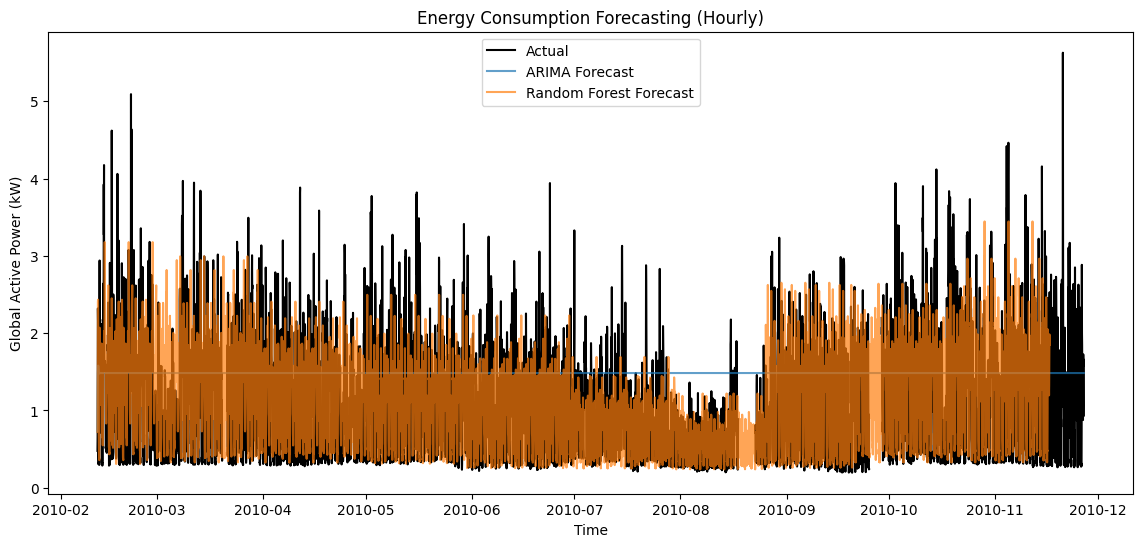

In [ ]:

# 10. Visualization
plt.figure(figsize=(14,6))

# Plot actual test values
plt.plot(test.index, test['Global_active_power'], label="Actual", color="black")

# Plot ARIMA forecast
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", alpha=0.7)

# Plot Random Forest forecast
plt.plot(test.index[:len(rf_forecast)], rf_forecast, label="Random Forest Forecast", alpha=0.7)

plt.legend()
plt.title("Energy Consumption Forecasting (Hourly)")
plt.xlabel("Time")
plt.ylabel("Global Active Power (kW)")
plt.show()
